<a href="https://colab.research.google.com/github/zwt4pb/labs/blob/main/lab02_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

**I am going to look at boats on craiglist. I will look at price and possibly length. **

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [5]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

url = 'https://charlottesville.craigslist.org/search/boo#search=1~gallery~0~0'
raw = requests.get(url, headers=header)
bsObj = soup(raw.content, 'html.parser')
listings = bsObj.find_all(class_ = 'cl-static-search-result')

In [14]:
import re

data = []
for k in range(len(listings)):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    length_ft = ''

    # Search for ft
    search = re.search(r"\b(\d{1,3})\s?(?:ft|'|feet)\b", title)
    if search:
        length_ft = search.group(1)
    else:
        length_ft = np.nan

    data.append({'title':title,'price':price,'length':length_ft})

In [15]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['length'] = pd.to_numeric(df['length'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_cars.csv')
df.head()

(34, 3)


,title,price,length
0,wave armor drive on pwc and boat ports,2200,NaN
1,john boat 3 trolling motors and battery,800,NaN
2,jon boat and vee bottom boat,200,NaN
3,14ft jon boat crestliner,2850,14.0
4,triton tr-175 fishing boat,6500,NaN


count        34.000000
mean      14844.970588
std       29274.552825
min           0.000000
25%         207.500000
50%        2350.000000
75%       13499.750000
max      134999.000000
Name: price, dtype: float64


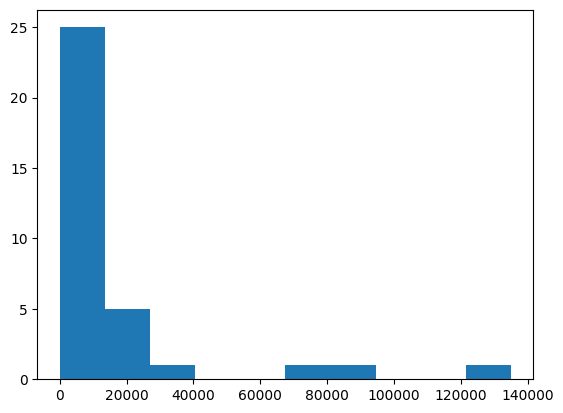

KeyError: 'age'

In [17]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

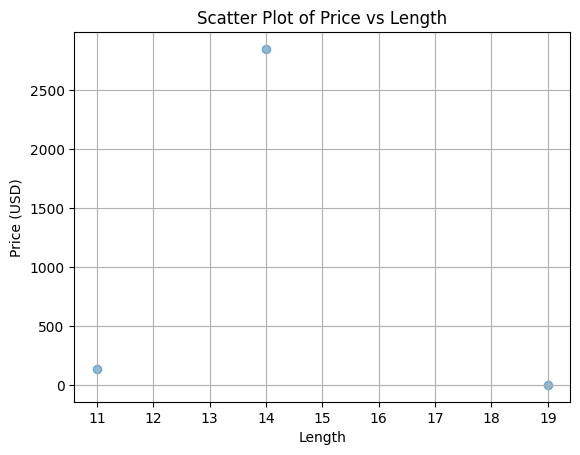

In [18]:
import matplotlib.pyplot as plt

# Scatter plot for Length vs Price
plt.scatter(df['length'], df['price'], alpha=0.5)
plt.title('Scatter Plot of Price vs Length')
plt.xlabel('Length')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


**Because not many lengths are listed, there is very few data for this plot.**

In [19]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['length'] = pd.to_numeric(df['length'],errors='coerce')
print(df.shape)
df.head(10)

(34, 3)


,title,price,length
0,wave armor drive on pwc and boat ports,2200,NaN
1,john boat 3 trolling motors and battery,800,NaN
2,jon boat and vee bottom boat,200,NaN
3,14ft jon boat crestliner,2850,14.0
4,triton tr-175 fishing boat,6500,NaN
5,outboard motor for sale!!!,1600,NaN
6,rinker boat for sale,2500,NaN
7,19ft rinker,0,19.0
8,"2-person intex inflatable kayak, well made, fi...",180,NaN
9,11ft coleman kayak,135,11.0


count        34.000000
mean      14844.970588
std       29274.552825
min           0.000000
25%         207.500000
50%        2350.000000
75%       13499.750000
max      134999.000000
Name: price, dtype: float64 



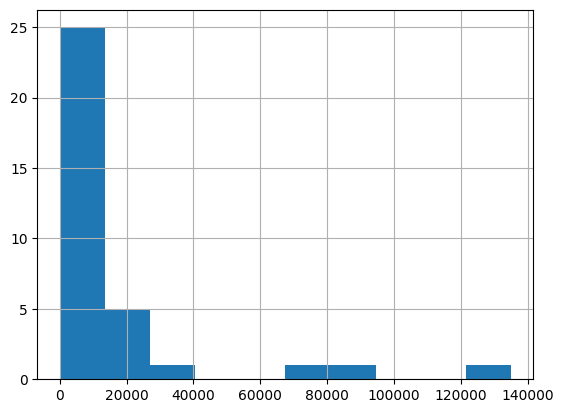

Listings missing length: 31
count     3.000000
mean     14.666667
std       4.041452
min      11.000000
25%      12.500000
50%      14.000000
75%      16.500000
max      19.000000
Name: length, dtype: float64


In [20]:
print(df['price'].describe(),'\n')
df['price'].hist()
plt.show()

print("Listings missing length:", df['length'].isnull().sum())
print(df['length'].describe())

In [21]:
df['price'].groupby(df['length']).mean()

,price
length,
11.0,135.0
14.0,2850.0
19.0,0.0


**I struggled a little to figure this lab out. I wasn't able to get more length values from craigslist in the data as numbers. Above is what I was able to figure out. **